# Calibration Project: Capital Flow Freezes ( Udara Peiris, 2024)

## Setup

### Packages

In [1]:
import requests
import pandas as pd
import xlrd
import os
import numpy as np

from scipy.optimize import fsolve
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Path and working directory

In [2]:
ROOT = os.path.dirname(os.getcwd())

PATH_DATA = os.path.join(ROOT, 'data')

## External Estimation of Parameters

The income shocks $y_l$ and $y_h$ are computed based on GDP per capita growth between 1996 and 2000 in upper middle income countries like Argentina.

In [3]:
# open the excel file with the GDP growth data
df_growth = pd.read_excel(os.path.join(PATH_DATA, 'GDP_growth - world - WB.xls'), sheet_name=0, header=0)

# delete the first two rows
df_growth = df_growth.iloc[2:]

# Define the columns to keep
columns_to_keep = ['Country Name', 'Country Code', 'Indicator Name', "2001", "2002", "2003", "2004", "2005"]

df_growth=df_growth[columns_to_keep]

# Create a new column 'average' with the average of columns 2001, 2002, 2003, 2004, 2005 for each row
df_growth['average'] = df_growth[['2001', '2002', '2003', '2004', '2005']].mean(axis=1)

# Handle NaN values by dropping rows with NaN in the 'average' column
df_growth = df_growth.dropna(subset=['average'])

#open the excel file with the country income classification data
df_classification = pd.read_excel(os.path.join(PATH_DATA, 'World_Bank_classification.xlsx'), sheet_name=0, header=0)

#keep only the columns "Code" and "Income group"
df_classification = df_classification[['Code', 'Income group']]

# Merge the df_growth and df_classification DataFrames
df_merged = pd.merge(df_growth, df_classification, left_on='Country Code', right_on='Code')

# keep only if income group is "Upper middle income"
df_merged = df_merged[(df_merged['Income group'] == 'Upper middle income')]

# Find the percentile rank of the Argentinian average GDP growth
average_ARG = df_merged.loc[df_merged['Country Code'] == "ARG", 'average'].values
percentile_rank_ARG = percentileofscore(df_merged['average'], average_ARG)

# Calculate the high growth rate
growth_h = np.percentile(df_merged['average'], 100-percentile_rank_ARG/1.5)
            #ideally high growth rate would be symmetric to low growth rate,
            #but I need an higher high growth rate than the symmetric one


The targeted debt to GDP ratio is based on the Argentinian debt to GDP ratio between 1996 and 2000.

In [4]:
# target debt to GDP ratio, b_0/y_0

## open excel file
df = pd.read_excel(os.path.join(PATH_DATA, 'debt_to_GDP - Argentina - IMF.xls'), sheet_name=1)

## Define the years to keep
years_to_keep = [1996, 1997, 1998, 1999, 2000]

## Filter the DataFrame to keep only the rows where Year is in the specified list
df_0 = df[df['Year'].isin(years_to_keep)]
df_0

## Calculate the average of the 'debt_to_GDP' variable
target_b_0_y_0 = df_0['debt_to_GDP'].mean()
target_b_0_y_0

np.float64(37.118)

## Internal Calibration

In [7]:
class Udara_Peiris_economy:
    """
    This class represents the economy of Udara Peiris in which the private sector takes on some debt.
    If it is impacted by a negative income shock, it can pass on its debt to the sovereign, which
    will negotiate a haircut with creditors. 

    Parameters:
        beta = time discount factor
        sigma = risk aversion coefficient
        g_l = growth rate in the low state
        g_h = growth rate in the high state
        y_0 = income in time 0
        y_l = low income in time 1 and 2
        g_h = high income in time 1 and 2
        kappa = loss of output if default  
    """
    def __init__(self,
                 beta=0.82,                             # time discount factor
                 sigma=2,                               # risk aversion
                 g_l=(1 + average_ARG / 100)**5 - 1,    # growth rate of the low state 
                 g_h=(1 + growth_h / 100)**5 - 1,       # growth rate of the high state
                 y_0=1,                                 # output in time 0
                 kappa=0.32,                            # loss of output (quarterly 2%)
                 n_delta=101,                           # number of points in the grid for delta
                 n_theta=101,                           # number of points in the grid for theta
                 target=target_b_0_y_0):                # target b_0/y_0

        # Calculate the low and high income in t=1 and t=2
        y_l = 1 + g_l
        y_h = 1 + g_h

        # Save parameters
        self.beta, self.sigma, self.kappa = beta, sigma, kappa
        self.g_l, self.g_h = g_l, g_h
        self.y_0, self.y_l, self.y_h = y_0, y_l, y_h
        self.n_delta, self.n_theta = n_delta, n_theta
        self.target = target

        # Create grids
        self.delta_b = np.linspace(0, 1, n_delta)
        self.delta_l = np.linspace(0, 1, n_delta)
        self.theta = np.linspace(0, 1, n_theta)
        self.q_0 = beta * (1 - self.delta_b / 2)


        # Allocate memory
        self.b_0 = None
        self.c_0 = None
        self.delta_L = None
        self.Theta = None
        self.B_0 = None
        self.m_omega = None
        self.max_delta_L_values = None
        self.max = None
        self.adjusted_indices = None
        self.delta_r = None
        self.index_target = None
        self.cali_b_0_y_0 = None
        

        # Initialize the economy
        self.solve_for_roots()  # Compute b_0 first
        self.c_0 = self.y_0 + self.q_0*self.b_0 # consumption in t=0
        self.initialize_meshgrids()  # Now b_0 is ready for meshgrid creation
        self.omega() # Compute omega values
        self.find_max_delta_L() # Find the highest delta_L values
        self.delta_rational() # Compute the rational delta values
        self.find_closest_b0_y0() # Find the closest b_0/y_0 value

    # Household FOC for b_0
    def HH_foc_b0(self, b_0, delta_b, q_0):
        LHS = (2 - delta_b) * (self.y_0 + q_0 * b_0)**(-self.sigma)
        RHS_1 = (1 - delta_b) * (self.y_l + self.beta * (1 - delta_b) / (1 + self.beta) * b_0 - (1 - delta_b) * b_0)**(-self.sigma)
        RHS_2 = (self.y_h - b_0 / (1 + self.beta))**(-self.sigma)
        return LHS - RHS_1 - RHS_2

    # Vectorized function to solve for the root for each combination of delta_b and q_0
    def solve_for_roots(self):
        initial_guess = 0.5

        # Wrapper function for fsolve
        def wrapper(delta_b, q_0):
            return fsolve(self.HH_foc_b0, initial_guess, args=(delta_b, q_0))[0]

        # Apply the wrapper function to each combination of delta_b and q_0
        self.b_0 = np.array([wrapper(delta_b, q_0) for delta_b, q_0 in zip(self.delta_b, self.q_0)])
        return self.b_0
    
        # consumption in t=0
        self.c_0 = self.y_0 + self.q_0*self.b_0
    
    # Plot b_0 as a function of delta_b
    def plot_b0_vs_delta_b(self):
              
        plt.figure(figsize=(10, 6))
        plt.plot(self.delta_b, self.b_0, linestyle='-', color='b')
        plt.xlabel('delta_b')
        plt.ylabel('b_0')
        plt.title('b_0 as a function of delta_b')
        plt.grid(True)
        plt.show()

    # Plot c_0 as a function of delta_b
    def plot_c0_vs_delta_b(self):

        plt.figure(figsize=(10, 6))
        plt.plot(self.delta_b, self.c_0, linestyle='-', color='red')
        plt.xlabel('delta_b')
        plt.ylabel('c_0')
        plt.title('c_0 as a function of delta_b')
        plt.grid(True)
        plt.show()    

    # Utility function
    def utility(self, c):
        return c**(1-self.sigma)/(1-self.sigma)
    
    # Meshgrid for delta_l, theta, and b_0
    def initialize_meshgrids(self):
        self.delta_L, self.Theta, self.B_0 = np.meshgrid(self.delta_l, self.theta, self.b_0, indexing='ij')
        
    # Nash bargaining function
    def omega(self):
        HS = ((1+self.beta)*self.utility(self.y_l - (1-self.delta_L)/(1+self.beta)*self.B_0)-self.utility(self.y_l)-self.beta*self.utility((1-self.kappa)*self.y_l))**self.Theta
        FS = (self.B_0*(1-self.delta_L))**(1-self.Theta)
        self.m_omega = HS*FS
        return self.m_omega
    
    # Find the highest value for each combination of theta and B_0, and return the corresponding delta_L values
    def find_max_delta_L(self):
        # Find the indices of the maximum omega values along the delta_L axis
        max_indices = np.argmax(self.m_omega, axis=0)
        self.max = np.max(self.m_omega, axis=0)

        # Map indices to corresponding delta_L values
        self.max_delta_L_values = self.delta_l[max_indices]

        return self.max_delta_L_values, self.max
    
    def plot_max_omega_surface(self):
        Theta, B_0 = np.meshgrid(self.theta, self.b_0, indexing="ij")
        if self.max is None:
            raise ValueError("Omega maximization has not been computed. Call find_max_delta_L() first.")
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(Theta, B_0, self.max, cmap='viridis', edgecolor='none')
        ax.set_xlabel('Theta')
        ax.set_ylabel('b_0')
        ax.set_zlabel('Max of Omega', labelpad=1.8)
        ax.set_title('3D Plot of Omega Maximization over delta_l')
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
        plt.show()
    
    
    def delta_rational(self):
        
        if self.max_delta_L_values is None or self.delta_l is None:
            raise ValueError("max_delta_L_values or delta_l is not initialized. Call find_max_delta_L() first.")
        
        # Create a matrix by tiling delta_b for comparison
        m_delta_b = np.tile(self.delta_b, (self.n_theta, 1))
        m_diff = abs(self.max_delta_L_values - m_delta_b)

        # Function to find the middle index of minimum values
        def middle_index_of_min(arr):
            min_value = np.min(arr)
            min_indices = np.where(arr == min_value)[0]
            middle_index = min_indices[len(min_indices) // 2]
            return middle_index

        # Apply the function along axis 1 (rows)
        self.adjusted_indices = np.apply_along_axis(middle_index_of_min, 1, m_diff).T

        # Compute the adjusted delta values
        self.delta_r = self.delta_b[self.adjusted_indices]
        return self.delta_r, self.adjusted_indices
    
    # 
    def find_closest_b0_y0(self):
        
        if self.b_0 is None:
            raise ValueError("b_0 is not initialized. Call solve_for_roots() first.")

        # Compute the absolute difference between target and b_0/y_0 values
        abs_diff = abs(self.b_0[self.adjusted_indices] * 100 - self.target)

        # Find the minimum value and all corresponding indices
        min_value = np.min(abs_diff)
        min_indices_several = np.where(abs_diff == min_value)[0]

        # Select the middle index of the minimum values
        self.index_target = min_indices_several[len(min_indices_several) // 2]

        # Extract the calibrated `b_0/y_0` value
        self.cali_b_0_y_0 = self.b_0[self.adjusted_indices][self.index_target]

        return self.cali_b_0_y_0, self.index_target
    
    def solution(self):
        self.plot_b0_vs_delta_b()
        self.plot_c0_vs_delta_b()
        self.plot_max_omega_surface()

        print(f"The target debt to GDP ratio is {self.target}")
        print(f"The calibrated debt to GDP ratio is {self.cali_b_0_y_0}")
        print(f"The rationale believed haircut is {self.delta_r[self.index_target]} and the optimal haircut is {self.max_delta_L_values[self.index_target, self.adjusted_indices[self.index_target] ]}")
        print(f"The Nash bargaining power is {self.theta[self.index_target]}")

          
    



The outputs and solution are given by the following code:

C:\Users\Maude\AppData\Local\Temp\ipykernel_21644\1804925297.py:124: RuntimeWarning: invalid value encountered in power
  HS = ((1+self.beta)*self.utility(self.y_l - (1-self.delta_L)/(1+self.beta)*self.B_0)-self.utility(self.y_l)-self.beta*self.utility((1-self.kappa)*self.y_l))**self.Theta


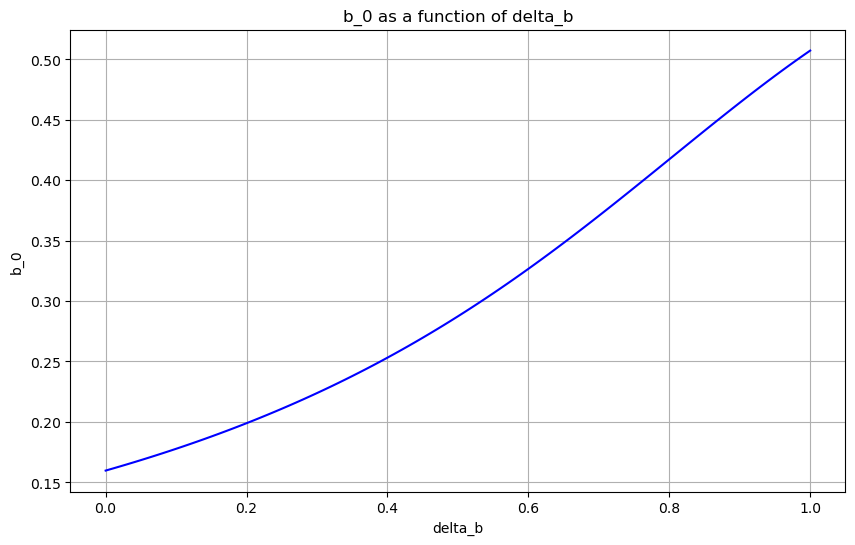

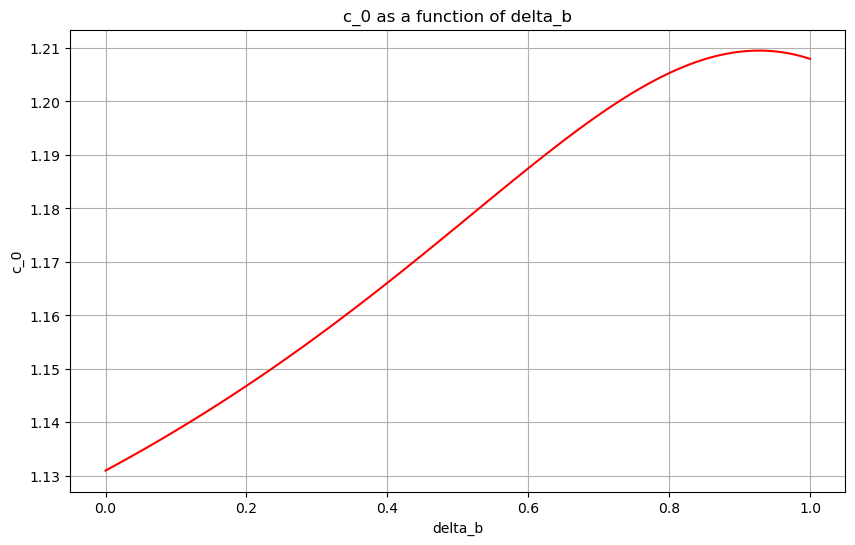

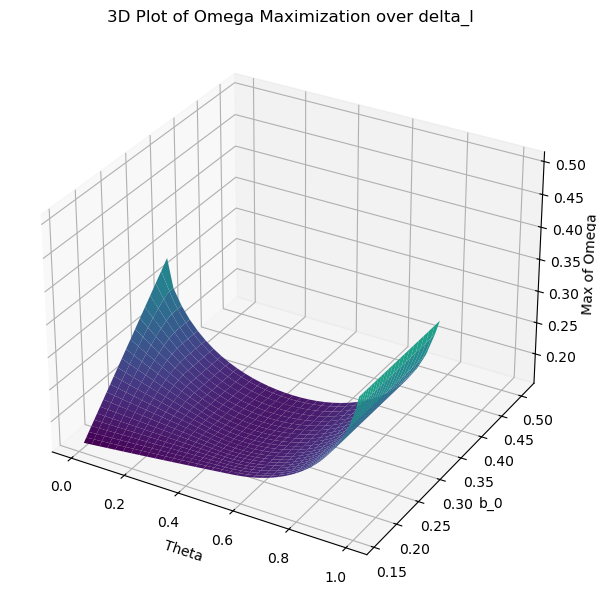

The target debt to GDP ratio is 37.118
The calibrated debt to GDP ratio is 0.3350617299218259
The rationale believed haircut is 0.62 and the optimal haircut is 0.79
The Nash bargaining power is 0.8200000000000001


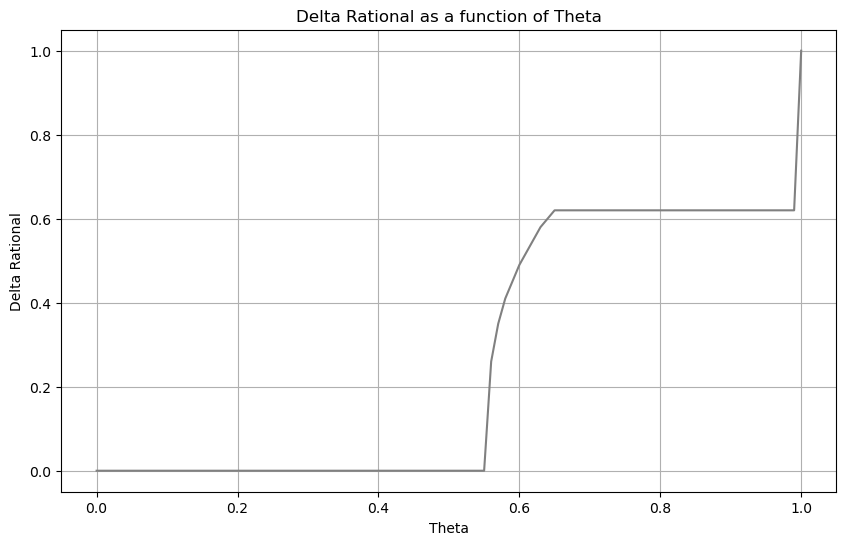

In [9]:
economy = Udara_Peiris_economy()

economy.solution()

# Create a plot of delta rational as a function of theta

economy.delta_rational()[0]
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(economy.theta, economy.delta_rational()[0], linestyle='-', color='grey')

# Set labels and title
plt.xlabel('Theta')
plt.ylabel('Delta Rational')
plt.title('Delta Rational as a function of Theta')

# Show grid
plt.grid(True)

# Show plot
plt.show()